In [5]:
# import required libraries
from vidgear.gears import CamGear
import cv2
import numpy as np
import torch
import time
from ultralytics import YOLO
import matplotlib.pyplot as plt
import ffmpeg

In [ ]:
model_path = "../data/model/piano_detection.pt"
device = torch.device("cuda")
model = YOLO(model_path)
model.to(device)


In [13]:


# Add any desire Video URL as input source
# for e.g https://vimeo.com/151666798
# and enable Stream Mode (`stream_mode = True`)
stream = CamGear(
    source="/opt/ml/level3_cv_finalproject-cv-08/01.mp4",
    logging=False,
    ).start()

In [20]:
start = stream.framerate * 50
end = stream.framerate * 70
idx = 0
total = []
while True:
    idx += 1
    frame = stream.read()
    if idx < start:
        continue
    elif idx > end:
        break
#     total.append(frame)
# frames = np.stack(total, axis=0)

In [19]:
frames.shape

(501, 1080, 1920, 3)

In [6]:
probe = ffmpeg.probe("/opt/ml/level3_cv_finalproject-cv-08/01.mp4")
video_info = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None) 
st = time.time()
out, _ = (
    ffmpeg
    .input("/opt/ml/level3_cv_finalproject-cv-08/01.mp4", ss=50, t=20)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24', loglevel="quiet")
    .run(capture_stdout=True)
)
ed = time.time()
print(f"time to ffmpeg : {ed-st:.4f} s")

st = time.time()    
frames = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, video_info['height'], video_info['width'], 3])
)
ed = time.time()
print(f"time to frames frombuffer : {ed-st:.4f} s")


time to ffmpeg : 7.7124 s
time to frames frombuffer : 0.0002 s


In [7]:
frames.shape

(500, 1080, 1920, 3)

In [4]:
stream.read().shape

(1080, 1920, 3)

In [106]:
stream.copy()

AttributeError: 'CamGear' object has no attribute 'copy'

In [ ]:
# 50 ~ 150 (100초)

# time to ffmpeg : 25.1046 s
# time to frames frombuffer : 0.0000 s
# time to detect : 5.6112 s
# time to preprocess : 43.4424 s
# time to making chunks : 42.2285 s

In [108]:
# set desired quality as 720p
options = {"STREAM_RESOLUTION": "720p" , "CAP_PROP_FPS" : 25}

# Add any desire Video URL as input source
# for e.g https://vimeo.com/151666798
# and enable Stream Mode (`stream_mode = True`)
stream = CamGear(
    source="https://www.youtube.com/watch?v=HB8-w5CvMls&ab_channel=PaulBarton",
    stream_mode=True,
    logging=False,
    **options
    ).start()

video_info = {}
total_frames = stream.ytv_metadata['duration'] * stream.ytv_metadata['fps']
start_frame = 50 * 25
end_frame = 150 * 25
idx = 0
key_xyxy = None
frames = []
frame_chunk = []
# loop over
st = time.time()
while True:
    idx += 1
    frame = stream.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if frame is None:
        break

    if idx < start_frame:
        continue
    elif idx > end_frame:
        break
    else:
        if key_xyxy is not None:
            xmin, ymin, xmax, ymax = key_xyxy
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            cropped = gray_frame[ymin:ymax, xmin:xmax]
            resized = cv2.resize(cropped, (900 ,100), interpolation=cv2.INTER_LINEAR) / 255.
            if len(frame_chunk) < 5:
                frame_chunk.append(resized)
            if len(frame_chunk) == 5:
                frames.append(frame_chunk.copy())
                frame_chunk.clear()

        else:
            st_det = time.time()
            pred = model.predict(source=frame, device='0', verbose=False)
            ed_det = time.time()
            if pred[0].boxes:
                if pred[0].boxes.conf.item() > 0.8:
                    key_xyxy = tuple(np.array(pred[0].boxes.xyxy.detach().cpu()[0], dtype=int))
                    xmin, ymin, xmax, ymax = key_xyxy
                    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                    cropped = gray_frame[ymin:ymax, xmin:xmax]
                    resized = cv2.resize(cropped, (900 ,100), interpolation=cv2.INTER_LINEAR) / 255.
                    frame_chunk.append(resized)

frames_with5 = torch.Tensor(np.array(frames)).float().cuda()
ed = time.time()
# safely close video stream
stream.stop()

print(f"total time : {ed - st:.4f} s")
print(f"det time : {ed_det - st_det:.4f} s")

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [103]:
frames_with5.shape

torch.Size([100, 5, 100, 900])

In [99]:
len(frames), len(frames[-1])

(100, 5)

In [101]:
for chunk in frames:
    for f in chunk:
        if f.shape != (900, 100):
            print(f.shape)

(100, 900)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900, 3)
(100, 900

In [100]:
frames_with5 = torch.Tensor(np.array(frames)).float().cuda()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (100, 5, 100, 900) + inhomogeneous part.

In [81]:
len(no_piano_frames), len(crop_piano_frames), 150 * 25 - 50 * 25 + 1

(0, 2501, 2501)

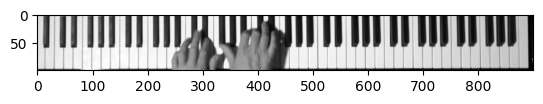

In [82]:
plt.imshow(crop_piano_frames[0], cmap="gray")

In [ ]:
video_info = {}
cap = cv2.VideoCapture(video_path)
start_frame = video_info['video_select_range'][0] * 25
end_frame = video_info['video_select_range'][1] * 25
idx = 1
key_xyxy = False
cv2_frames = []
frame_chunk = []
while True:
    _, frame = cap.read()
    if idx < start_frame:
        continue
    elif idx > end_frame:
        break
    else:
        if key_xyxy:
            xmin, ymin, xmax, ymax = key_xyxy
            cropped = frame[ymin:ymax, xmin:xmax]
        else:
            pred = model.predict(source=frame, device='0', verbose=False)
            if pred[0].boxes:
                if pred[0].boxes.conf.item() > 0.8:
                    key_xyxy = tuple(np.array(pred[0].boxes.xyxy.detach().cpu()[0], dtype=int))
                    cv2.imwrite("02.jpg", cv2.cvtColor(frame[ymin:ymax, xmin:xmax], cv2.COLOR_BGR2GRAY))
                    start_idx = i
                    key_detected = True
                    break
        

st = time.time()
out, _ = (
    ffmpeg
    .input(video_path, ss=video_info['video_select_range'][0], t=video_info['video_select_range'][1]-video_info['video_select_range'][0])
    .output('pipe:', format='rawvideo', pix_fmt='rgb24', loglevel="quiet")
    .run(capture_stdout=True)
)
ed = time.time()
print(f"time to ffmpeg : {ed-st:.4f} s")

st = time.time()    
frames = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, video_info['height'], video_info['width'], 3])
)
ed = time.time()
print(f"time to frames frombuffer : {ed-st:.4f} s")


key_detected = False
st = time.time()
for i, frame in enumerate(frames):
    # Piano Detection
    if not key_detected:
        pred = model.predict(source=frame, device='0', verbose=False)
        if pred[0].boxes:
            if pred[0].boxes.conf.item() > 0.8:
                xmin, ymin, xmax, ymax = tuple(np.array(pred[0].boxes.xyxy.detach().cpu()[0], dtype=int))
                cv2.imwrite("02.jpg", cv2.cvtColor(frame[ymin:ymax, xmin:xmax], cv2.COLOR_BGR2GRAY))
                start_idx = i
                key_detected = True
                break
ed = time.time()
print(f"time to detect : {ed-st:.4f} s")

st = time.time()
if key_detected:
    frames = np.mean(frames[start_idx:, ymin:ymax, xmin:xmax, ...], axis=3)
    frames = np.stack([cv2.resize(f, (900 ,100), interpolation=cv2.INTER_LINEAR) for f in frames], axis=0) / 255.
else:
    # 영상 전체에서 Top View 피아노가 없을 경우 None 반환
    return None
ed = time.time()
print(f"time to preprocess : {ed-st:.4f} s")
    
# 5 frame 씩
st = time.time()
frames_with5 = []
for i in range(len(frames)):
    if i >= 2 and i < len(frames)-2:
        file_list = [frames[i-2], frames[i-1], frames[i], frames[i+1], frames[i+2]]
    elif i < 2:
        file_list = [frames[i], frames[i], frames[i], frames[i+1], frames[i+2]]
    else:
        file_list = [frames[i-2], frames[i-1], frames[i], frames[i], frames[i]]
    frames_with5.append(file_list)

frames_with5 = torch.Tensor(np.array(frames_with5)).float().cuda()
ed = time.time()
print(f"time to making chunks : {ed-st:.4f} s")